In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import matplotlib.pyplot as plt
import matplotlib
from skimage.io import imread
from io_utils import return_filenames

from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesAtlas
)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [10]:
!pip3 list

Package                       Version
----------------------------- -------------------
alabaster                     0.7.12
appdirs                       1.4.3
argon2-cffi                   20.1.0
asn1crypto                    0.24.0
astroid                       2.4.2
async-generator               1.10
attr                          0.3.1
attrs                         20.3.0
Automat                       0.6.0
awscli                        1.18.181
Babel                         2.9.0
backcall                      0.2.0
bleach                        3.2.1
blinker                       1.4
bokeh                         2.2.3
boto                          2.49.0
boto3                         1.16.21
botocore                      1.19.21
cached-property               1.5.2
certifi                       2020.11.8
cffi                          1.14.3
chardet                       3.0.4
click                         6.7
cloud-init                    20.4
cmake                         3.18.4.

In [2]:
# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

# Input parameters:
rendered_image_size = 1024  
camera_distance = 20
elevation = 0
azimuth_list = [0, 30, 60, 90, 120, 150, 180]

obj_filename = "data/textured-scans/1553_KX16_OptiTexAdamF3_ateamleft_out.obj"

cuda:0


In [3]:
def setup_renderer(image_size, camera_distance, elevation, azimuth):

    print("Image size: " + str(image_size) + ", elevation: " + str(elevation) + ", azimuth: " + str(azimuth))
    raster_settings = RasterizationSettings(
    image_size=rendered_image_size, 
    faces_per_pixel=1,)

    # Set up field-of-view rotation and translation matrices
    R, T = look_at_view_transform(camera_distance, elevation, azimuth) 
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    lights = PointLights(device=device, location=[[1000.0, 1000.0, -500.0]])
    
    # Set up MeshRenderer class
    renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,)
    )
    return renderer
    

def setup_mesh(obj_filename):

        
    print("Rendering " + str(obj_filename))
    
    verts, faces, aux = load_obj(
    obj_filename,
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat",
    #texture_wrap= "clamp"
    #texture_wrap= None,
     )

    # Create Meshes class using vertices and faces from the .obj file. Uses TexturesAtlas 
    # method to store heterogeneous textures per mesh
    atlas = aux.texture_atlas
    mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),)
    return mesh


def render_mesh(mesh, renderer):

    image = renderer(mesh)
    if device == torch.device("cuda:0"):
        im_array = image[0, ..., :3].cpu().detach().numpy()
    else:
        im_array = image[0, ..., :3].numpy()
    return im_array


Rendering data/textured-scans/1553_KX16_OptiTexAdamF3_ateamleft_out.obj


/home/ubuntu/.local/lib/python3.6/site-packages/pytorch3d/io/mtl_io.py:95: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


Image size: 1024, elevation: 0, azimuth: 0
Rendering data/textured-scans/1553_KX16_OptiTexAdamF3_ateamleft_out.obj
Image size: 1024, elevation: 0, azimuth: 30
Rendering data/textured-scans/1553_KX16_OptiTexAdamF3_ateamleft_out.obj
Image size: 1024, elevation: 0, azimuth: 60
Rendering data/textured-scans/1553_KX16_OptiTexAdamF3_ateamleft_out.obj
Image size: 1024, elevation: 0, azimuth: 90


RuntimeError: CUDA error: device-side assert triggered

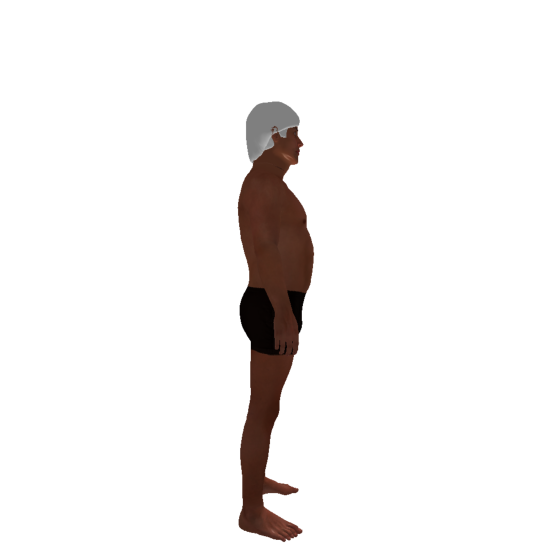

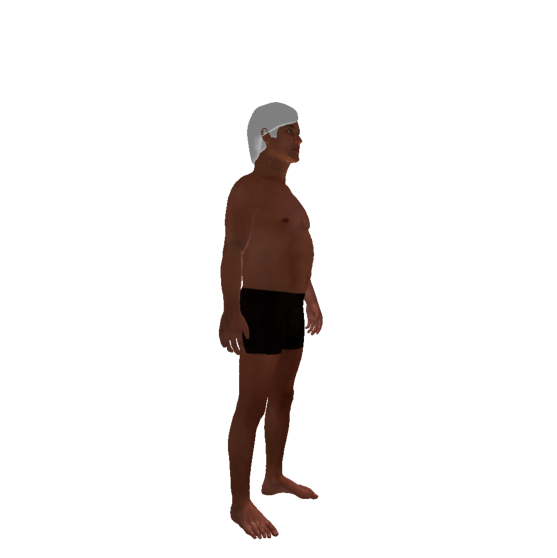

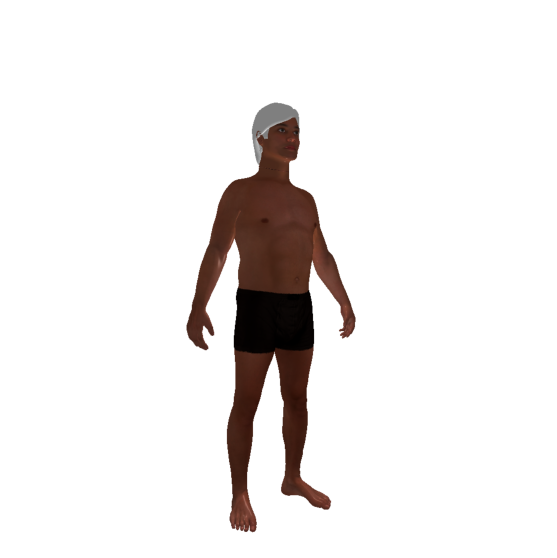

In [4]:
for azimuth_value in azimuth_list:
    mesh = setup_mesh(obj_filename)
    renderer = setup_renderer(rendered_image_size, camera_distance, elevation, azimuth_value)
    im_array = render_mesh(mesh, renderer)

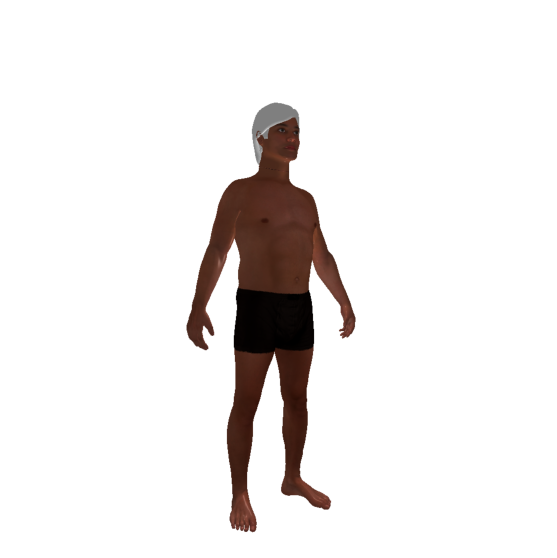

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(im_array)
plt.grid("off");
plt.axis("off");